In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import os
import matplotlib.pyplot as plt

In [10]:
# Using ResNet block(revised)
class Block(nn.Module):
  def __init__(self, in_ch, out_ch, with_BN, stride=1):
    super(Block, self).__init__()
    self.with_BN = with_BN

    # adjust stride value for smaller width and height
    self.conv1 = nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)
    if with_BN:
      self.bn1 = nn.BatchNorm2d(out_ch)
    
    # same width and height (using 1 padding)
    self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False)
    if with_BN:
      self.bn2 = nn.BatchNorm2d(out_ch)

    self.skipconnection = nn.Sequential() # identity mapping
    if stride != 1: # not identity mapping
      modules = [nn.Conv2d(in_ch, out_ch, kernel_size=1, stride=stride, bias=False)]
      if with_BN:
        modules.append(nn.BatchNorm2d(out_ch))
      self.skipconnection = nn.Sequential(*modules)
    
  def forward(self, x):
    if self.with_BN:
      out = F.relu(self.bn1(self.conv1(x)))
      out = self.bn2(self.conv2(out))
    else:
      out = F.relu(self.conv1(x))
      out = self.conv2(out)
    out += self.skipconnection(x)
    out = F.relu(out)
    return out

class ResNet(nn.Module):
  def __init__(self, block, num_blocks, with_BN, num_classes=10):
    super(ResNet, self).__init__()
    self.in_ch = 64
    self.with_BN = with_BN

    # Using 64 filters (3x3)
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    if with_BN:
      self.bn1 = nn.BatchNorm2d(64)
    self.layer1 = self._layer(block, 64, with_BN, num_blocks[0], stride=1)
    self.layer2 = self._layer(block, 128, with_BN, num_blocks[1], stride=2)
    self.layer3 = self._layer(block, 256, with_BN, num_blocks[2], stride=2)
    self.layer4 = self._layer(block, 512, with_BN, num_blocks[3], stride=2)
    self.linear = nn.Linear(512, num_classes)

  def _layer(self, block, out_ch, with_BN, num_blocks, stride):
    strides = [stride] + [1] * (num_blocks - 1)
    layers = []
    for stride in strides:
      layers.append(block(self.in_ch, out_ch, with_BN, stride))
      self.in_ch = out_ch # change the channel for the next layer
    return nn.Sequential(*layers)

  def forward(self, x):
    if self.with_BN:
      out = F.relu(self.bn1(self.conv1(x)))
    else:
      out = F.relu(self.conv1(x))
    out = self.layer1(out)
    out = self.layer2(out) 
    out = self.layer3(out)
    out = self.layer4(out)
    out = F.avg_pool2d(out, 4) 
    out = out.view(out.size(0), -1) 
    out = self.linear(out)
    return out 

In [11]:
def ResNet18(with_BN):
  return ResNet(Block, [2,2,2,2], with_BN)

In [12]:
import torchvision
import torchvision.transforms as transforms

In [13]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [14]:
criterion = nn.CrossEntropyLoss()

def train(net, optimizer, epoch, step):
  net.train()
  correct = 0 # number of image that is correctly classified
  total = 0
  steps = [] # training step
  losses = [] # loss at every step

  for _, (inputs, targets) in enumerate(train_loader):
    inputs, targets = inputs.cuda(), targets.cuda()

    optimizer.zero_grad()
    outputs = net(inputs)
    loss = criterion(outputs, targets)
    loss.backward()
    optimizer.step()

    _, predicted = outputs.max(1)
    correct += predicted.eq(targets).sum().item()
    total += targets.size(0)

    steps.append(step)
    losses.append(loss.item())
    step += 1

  return correct / total, steps, losses

def test(net, optimizer, epoch):
  net.eval()
  correct = 0
  total = 0
  loss = 0

  for batch_idx, (inputs, targets) in enumerate(test_loader):
    inputs, targets = inputs.cuda(), targets.cuda()

    outputs = net(inputs)
    loss += criterion(outputs, targets).item()

    _, predicted = outputs.max(1)
    correct += predicted.eq(targets).sum().item()
    total += targets.size(0)

  return correct / total, loss

## Without BN

In [15]:
net = ResNet18(with_BN=False).cuda()
learning_rate = 0.01
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Total parameters", total_params)

Total parameters 11164362


In [16]:
without_BN_train_accuracies = []
without_BN_steps = []
without_BN_train_losses = []
without_BN_test_accuracies = []
without_BN_test_losses = []

epochs = 20

for epoch in range(0, epochs):
  print(f'[ Epoch: {epoch}/{epochs} ]')
  train_accuracy, steps, train_losses = train(net, optimizer, epoch, len(without_BN_steps))
  without_BN_train_accuracies.append(train_accuracy)
  without_BN_steps.extend(steps)
  without_BN_train_losses.extend(train_losses)
  print(f'Train accuracy = {train_accuracy * 100:.2f} / Train loss = {sum(train_losses)}')

  test_accuracy, test_loss = test(net, optimizer, epoch)
  without_BN_test_accuracies.append(test_accuracy)
  without_BN_test_losses.append(test_loss)
  print(f'Test accuracy = {test_accuracy * 100:.2f} / Test loss = {test_loss}')

[ Epoch: 0/20 ]
Train accuracy = 11.28 / Train loss = 895.538343667984
Test accuracy = 19.61 / Test loss = 226.63039231300354
[ Epoch: 1/20 ]
Train accuracy = 23.44 / Train loss = 804.0327450037003
Test accuracy = 30.34 / Test loss = 195.73157727718353
[ Epoch: 2/20 ]
Train accuracy = 32.33 / Train loss = 718.2090593576431
Test accuracy = 33.45 / Test loss = 181.98686146736145
[ Epoch: 3/20 ]
Train accuracy = 38.54 / Train loss = 654.16816842556
Test accuracy = 39.71 / Test loss = 165.9757515192032
[ Epoch: 4/20 ]
Train accuracy = 42.61 / Train loss = 615.1765345335007
Test accuracy = 47.40 / Test loss = 144.98353457450867
[ Epoch: 5/20 ]
Train accuracy = 46.14 / Train loss = 580.554481625557
Test accuracy = 48.37 / Test loss = 141.2668081521988
[ Epoch: 6/20 ]
Train accuracy = 49.84 / Train loss = 543.1465729475021
Test accuracy = 52.96 / Test loss = 130.01174437999725
[ Epoch: 7/20 ]
Train accuracy = 53.33 / Train loss = 508.4651166200638
Test accuracy = 54.31 / Test loss = 128.29171

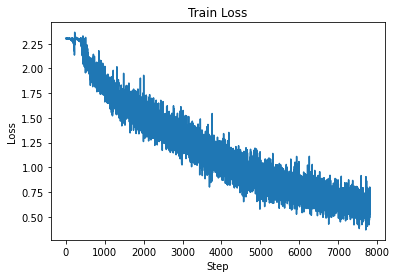

In [17]:
plt.plot(without_BN_steps, without_BN_train_losses)
plt.title('Train Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

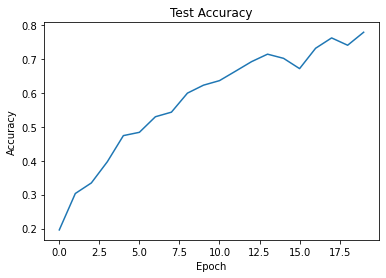

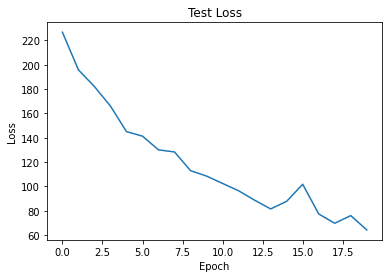

In [18]:
plt.plot([i for i in range(len(without_BN_test_accuracies))], without_BN_test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot([i for i in range(len(without_BN_test_losses))], without_BN_test_losses)
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

## With BN

In [19]:
net = ResNet18(with_BN=True).cuda()
learning_rate = 0.01
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.0002)

total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
print("Total parameters", total_params)

Total parameters 11173962


In [20]:
with_BN_train_accuracies = []
with_BN_steps = []
with_BN_train_losses = []
with_BN_test_accuracies = []
with_BN_test_losses = []

epochs = 20

for epoch in range(0, epochs):
  print(f'[ Epoch: {epoch}/{epochs} ]')
  train_accuracy, steps, train_losses = train(net, optimizer, epoch, len(with_BN_steps))
  with_BN_train_accuracies.append(train_accuracy)
  with_BN_steps.extend(steps)
  with_BN_train_losses.extend(train_losses)
  print(f'Train accuracy = {train_accuracy * 100:.2f} / Train loss = {sum(train_losses)}')

  test_accuracy, test_loss = test(net, optimizer, epoch)
  with_BN_test_accuracies.append(test_accuracy)
  with_BN_test_losses.append(test_loss)
  print(f'Test accuracy = {test_accuracy * 100:.2f} / Test loss = {test_loss}')

[ Epoch: 0/20 ]
Train accuracy = 46.28 / Train loss = 576.3917135596275
Test accuracy = 49.94 / Test loss = 157.85252714157104
[ Epoch: 1/20 ]
Train accuracy = 65.56 / Train loss = 376.46925473213196
Test accuracy = 69.56 / Test loss = 88.4546617269516
[ Epoch: 2/20 ]
Train accuracy = 74.64 / Train loss = 283.47492012381554
Test accuracy = 69.23 / Test loss = 94.09936332702637
[ Epoch: 3/20 ]
Train accuracy = 78.93 / Train loss = 236.06384721398354
Test accuracy = 72.25 / Test loss = 83.1465115249157
[ Epoch: 4/20 ]
Train accuracy = 81.83 / Train loss = 205.78099954128265
Test accuracy = 81.59 / Test loss = 55.263458371162415
[ Epoch: 5/20 ]
Train accuracy = 83.58 / Train loss = 184.66668483614922
Test accuracy = 81.52 / Test loss = 54.826446533203125
[ Epoch: 6/20 ]
Train accuracy = 85.42 / Train loss = 164.62448538839817
Test accuracy = 84.50 / Test loss = 47.46951733529568
[ Epoch: 7/20 ]
Train accuracy = 86.83 / Train loss = 149.66326522827148
Test accuracy = 82.34 / Test loss = 54

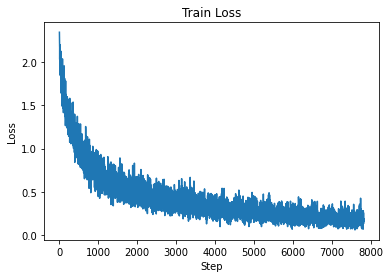

In [22]:
plt.plot(with_BN_steps, with_BN_train_losses)
plt.title('Train Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.show()

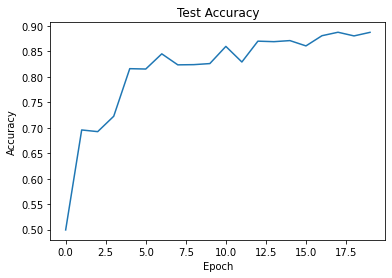

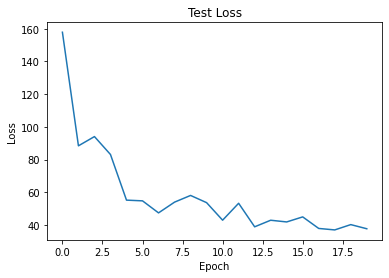

In [23]:
plt.plot([i for i in range(len(with_BN_test_accuracies))], with_BN_test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

plt.plot([i for i in range(len(with_BN_test_losses))], with_BN_test_losses)
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

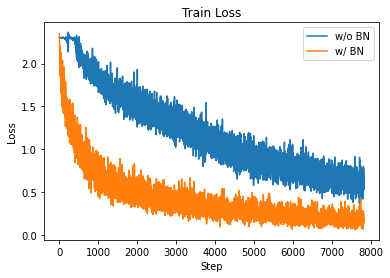

In [24]:
plt.plot(without_BN_steps, without_BN_train_losses)
plt.plot(with_BN_steps, with_BN_train_losses)
plt.title('Train Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend(['w/o BN', 'w/ BN'])
plt.show()

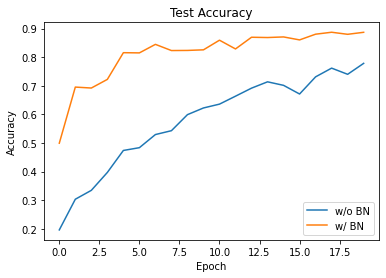

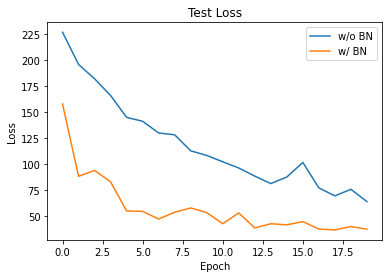

In [25]:
plt.plot([i for i in range(len(without_BN_test_accuracies))], without_BN_test_accuracies)
plt.plot([i for i in range(len(with_BN_test_accuracies))], with_BN_test_accuracies)
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['w/o BN', 'w/ BN'])
plt.show()

plt.plot([i for i in range(len(without_BN_test_losses))], without_BN_test_losses)
plt.plot([i for i in range(len(with_BN_test_losses))], with_BN_test_losses)
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['w/o BN', 'w/ BN'])
plt.show()